In [ ]:
from google.colab import drive
drive.mount('/gdrive')
root = '/gdrive/My Drive/Colab Notebooks/MNIST-classification/data'

Mounted at /gdrive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

from scipy.io import loadmat

from IPython.display import clear_output

In [ ]:
X = loadmat(os.path.join(root, 'mnist_training_data' ))['training_data']
y = loadmat(os.path.join(root, 'mnist_training_label'))['training_label']

X_test = loadmat(os.path.join(root, 'mnist_test_data'))['test_data']
y_test = loadmat(os.path.join(root, 'mnist_test_label'))['test_label']

train_size, n_features = X.shape
test_size, _ = X_test.shape
seed = 42

shuffled_indices = np.random.permutation(train_size)
X = X[shuffled_indices]
y = y[shuffled_indices]

print(f"No. of features:\t\t{n_features}")
print(f"No. of training examples:\t{train_size}")
print(f"No. of test examples:\t\t{test_size}")

No. of features:		784
No. of training examples:	50000
No. of test examples:		10000


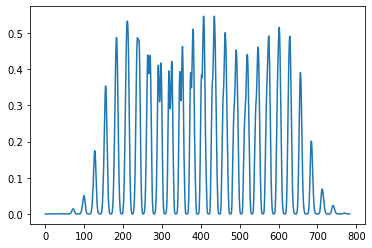

In [ ]:

plt.plot(np.mean(X, axis=0))

In [ ]:
def show_example(X, y, y_pred=None, *, nrow=2, ncol=6):
    y = y.ravel()
    sample_indices = np.random.choice(X.shape[0], size=nrow*ncol, replace=False)
    title = 'Sample Predictions' if y_pred is not None else 'Sample Images'

    fig, axs = plt.subplots(nrows=nrow, ncols=ncol)
    fig.suptitle(title, fontsize='x-large')
    fig.set_size_inches(ncol*2, nrow*2 + 1)
    axs = axs.ravel()
    for ax_idx, im_idx in enumerate(sample_indices):
        image = X[im_idx].reshape(28, 28)
        axs[ax_idx].imshow(image)
        axs[ax_idx].get_xaxis().set_visible(False)
        axs[ax_idx].get_yaxis().set_visible(False)
        if y_pred is None:
            axs[ax_idx].set_title(f"Label: {y[im_idx]}")
        else:
            out_org, out_pred = y[im_idx], y_pred[im_idx]
            axs[ax_idx].set_title(f"Actual Label: {out_org}\n" \
                                  f"Predicted Label: {out_pred}", 
                            color='green' if out_org == out_pred else 'red')
    fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
    fig.show()

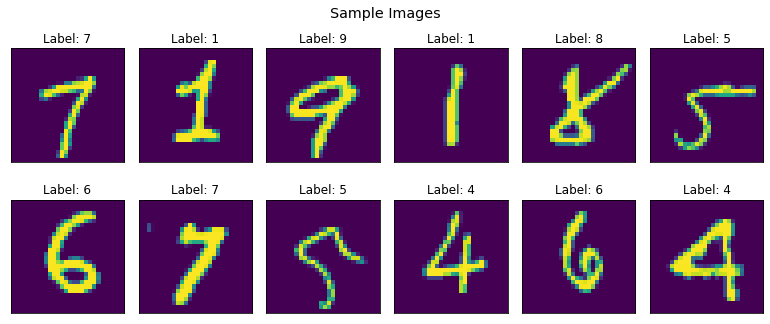

In [ ]:
show_example(X, y)

# Neural Network

## Required Functions

In [ ]:
def plot_training_history(training_history, title='Training History'):
    train_loss = training_history.history['loss']
    valid_loss = training_history.history['val_loss']
    train_acc = training_history.history['accuracy']
    valid_acc = training_history.history['val_accuracy']

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    fig.set_size_inches(15, 5)

    ax1.plot(train_loss, label='Training Loss')
    ax1.plot(valid_loss, label='Validation Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(train_acc, label='Training Accuracy')
    ax2.plot(valid_acc, label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.legend()

    fig.show()

In [ ]:
def predict(model, X):
    return np.argmax(model.predict(X), axis=-1)

## Training

In [ ]:
!pip install keras-tuner
clear_output()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras_tuner import HyperModel, RandomSearch

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f"No. of GPUs available: {len(physical_devices)}")
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

No. of GPUs available: 1


In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=seed)
train_idx, val_idx = [*sss.split(X, y)][0]

X_train, X_val = X[train_idx, :], X[val_idx, :]
y_train, y_val = y[train_idx, :], y[val_idx, :]

In [ ]:
class MyHyperModel(HyperModel):
    def __init__(self, classes, layers):
        self.classes = classes
        self.layers = layers

    def build(self, hp):
        # Build Model
        model = keras.Sequential()
        for i in range(self.layers):
            model.add(layers.Dense(
                units=hp.Choice(f"layer_{i+1:02}", values=list(range(16, 513, 16))),
                kernel_initializer='he_uniform',
                activation='relu'
            ))

        model.add(layers.Dense(self.classes, activation='softmax'))
        
        # Compile Model
        model.compile(
            optimizer=keras.optimizers.Adam(0.001),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )
        return model

In [ ]:
params = {}
for i in range(10):
    print(f"Number of Hidden Layers: {i+1}")
    hypermodel = MyHyperModel(10, i+1)

    tuner = RandomSearch(
        hypermodel,
        objective='val_accuracy',
        max_trials=20,
        overwrite=True
    )

    es = keras.callbacks.EarlyStopping(patience=20)
    tuner.search(
        X_train, y_train, validation_data=(X_val, y_val),
        epochs=500, batch_size=10000, verbose=1 , callbacks=[es]
    )
    params[i+1] = tuner.get_best_hyperparameters()[0].values

Trial 20 Complete [00h 00m 10s]
val_accuracy: 0.9684000015258789

Best val_accuracy So Far: 0.972000002861023
Total elapsed time: 00h 03m 41s
INFO:tensorflow:Oracle triggered exit


In [ ]:
params

{1: {'layer_01': 464},
 2: {'layer_01': 416, 'layer_02': 496},
 3: {'layer_01': 496, 'layer_02': 272, 'layer_03': 80},
 4: {'layer_01': 368, 'layer_02': 304, 'layer_03': 384, 'layer_04': 224},
 5: {'layer_01': 496,
  'layer_02': 256,
  'layer_03': 144,
  'layer_04': 128,
  'layer_05': 448},
 6: {'layer_01': 336,
  'layer_02': 464,
  'layer_03': 144,
  'layer_04': 288,
  'layer_05': 64,
  'layer_06': 80},
 7: {'layer_01': 448,
  'layer_02': 352,
  'layer_03': 144,
  'layer_04': 144,
  'layer_05': 48,
  'layer_06': 224,
  'layer_07': 464},
 8: {'layer_01': 208,
  'layer_02': 48,
  'layer_03': 336,
  'layer_04': 512,
  'layer_05': 160,
  'layer_06': 336,
  'layer_07': 288,
  'layer_08': 464},
 9: {'layer_01': 352,
  'layer_02': 192,
  'layer_03': 336,
  'layer_04': 64,
  'layer_05': 160,
  'layer_06': 48,
  'layer_07': 416,
  'layer_08': 240,
  'layer_09': 192},
 10: {'layer_01': 480,
  'layer_02': 368,
  'layer_03': 80,
  'layer_04': 352,
  'layer_05': 480,
  'layer_06': 304,
  'layer_07

In [ ]:
def create_model(input_size, num_units):
    model = Sequential()
    model.add(layers.InputLayer(input_size))
    for units in num_units.values():
        model.add(layers.Dense(
            units, 
            activation='relu', 
            kernel_initializer='he_uniform'
        ))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001), 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )
    return model

models = []
for num_units in params.values():
    model = create_model(n_features, num_units)
    models.append(model)

In [ ]:
for model in models:
    print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 464)               364240    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                4650      
Total params: 368,890
Trainable params: 368,890
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 416)               326560    
_________________________________________________________________
dense_14 (Dense)             (None, 496)               206832    
_________________________________________________________________
dense_15 (Dense)             (None, 10)                4970      
Total params: 538,362

In [ ]:
es = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    mode='auto', 
    patience=20, 
    verbose=1, 
    restore_best_weights=True
)

In [ ]:
from sklearn.model_selection import StratifiedKFold

results = pd.DataFrame(columns=['n_layers', 'train_loss', 'train_acc', 'val_loss', 'val_acc'])
for i, model in enumerate(models):
    model.save_weights('model.h5')
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for train_idx, valid_idx in skf.split(X, y):
        print(f"Training Model {i+1}:")
        model.load_weights('model.h5')

        X_train, X_valid = X[train_idx, :], X[valid_idx, :]
        y_train, y_valid = y[train_idx, :], y[valid_idx, :]

        training_history = model.fit(
            X_train, y_train, validation_data=(X_valid, y_valid),
            epochs=500, batch_size=10000,
            shuffle=True, verbose=1, callbacks=[es]
        )
        clear_output()

        train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
        valid_loss, valid_acc = model.evaluate(X_valid, y_valid, verbose=0)

        results = results.append(dict(
            n_layers=len(model.layers)- 1,
            train_loss=train_loss,
            train_acc=train_acc,
            val_loss=valid_loss,
            val_acc=valid_acc
        ), ignore_index=True)

In [ ]:
gb = results.groupby('n_layers').aggregate(np.mean)
num_layers = gb['val_acc'].idxmax().astype('int')
gb

,train_loss,train_acc,val_loss,val_acc
n_layers,,,,
1.0,0.012115,0.999095,0.087063,0.97614
2.0,0.003877,0.999790,0.094809,0.97652
3.0,0.003478,0.999750,0.101688,0.97622
4.0,0.001908,0.999940,0.113927,0.97540
5.0,0.001120,0.999980,0.126490,0.97512
6.0,0.002464,0.999880,0.123472,0.97360
7.0,0.001603,0.999920,0.135845,0.97384
8.0,0.008879,0.998240,0.176146,0.96580
9.0,0.003093,0.999440,0.193431,0.97032


In [ ]:
num_layers

4

In [ ]:
model = create_model(
    n_features, 
    num_layers, 
    [params[num_layers - 1][f'layer_{i+1}'] for i in range(num_layers)]
)

TypeError: ignored

Epoch 1/20
5/5 [==============================] - 2s 272ms/step - loss: 2.0170 - accuracy: 0.3671 - val_loss: 1.4191 - val_accuracy: 0.6924
Epoch 2/20
5/5 [==============================] - 1s 224ms/step - loss: 1.1957 - accuracy: 0.7516 - val_loss: 0.8532 - val_accuracy: 0.8142
Epoch 3/20
5/5 [==============================] - 1s 220ms/step - loss: 0.7567 - accuracy: 0.8222 - val_loss: 0.6003 - val_accuracy: 0.8420
Epoch 4/20
5/5 [==============================] - 1s 219ms/step - loss: 0.5550 - accuracy: 0.8527 - val_loss: 0.4763 - val_accuracy: 0.8688
Epoch 5/20
5/5 [==============================] - 1s 235ms/step - loss: 0.4543 - accuracy: 0.8759 - val_loss: 0.4143 - val_accuracy: 0.8836
Epoch 6/20
5/5 [==============================] - 1s 230ms/step - loss: 0.3977 - accuracy: 0.8884 - val_loss: 0.3710 - val_accuracy: 0.8954
Epoch 7/20
5/5 [==============================] - 1s 230ms/step - loss: 0.3599 - accuracy: 0.8978 - val_loss: 0.3413 - val_accuracy: 0.9034
Epoch 8/20
5/5 [====

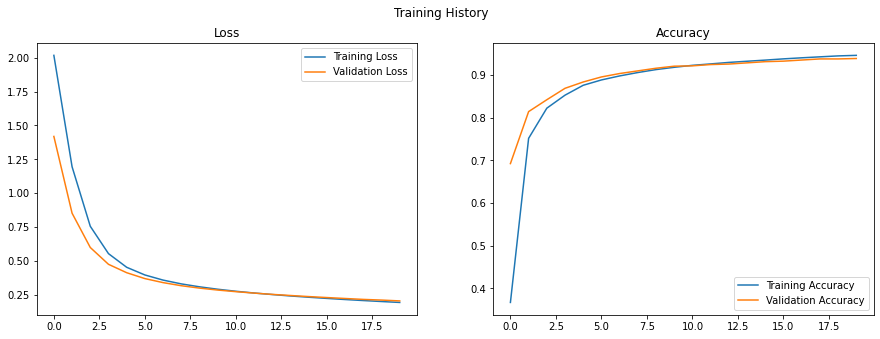

In [ ]:
model = Sequential([
    layers.Dense(368, activation='relu', kernel_initializer='he_uniform'),
    # layers.Dense(394, activation='relu', kernel_initializer='he_uniform'),
    # layers.Dense(32, activation='relu', kernel_initializer='he_uniform'),
    # layers.Dense(32, activation='relu', kernel_initializer='he_uniform'),
    layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

es = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    mode='auto', 
    patience=20, 
    verbose=1, 
    restore_best_weights=True
)

training_history = model.fit(
    X_train, y_train, validation_data=(X_val, y_val),
    epochs=20, batch_size=10000,
    shuffle=True, verbose=1, callbacks=[es]
)

plot_training_history(training_history)

In [ ]:
def accuracy(model, X, y):
    y_pred = predict(model, X)
    return np.mean(y_pred.ravel() == y.ravel())

In [ ]:
nn_train_loss, nn_train_acc = model.evaluate(X_train, y_train, verbose=0)
nn_test_loss,  nn_test_acc  = model.evaluate(X_test,  y_test,  verbose=0)

print(f"Training Accuracy: {nn_train_acc:2.2%}")
print(f"Test Accuracy:     {nn_test_acc :2.2%}")
print(f"Training Loss: {nn_train_loss:.6}")
print(f"Test Loss:     {nn_test_loss :.6}")

Training Accuracy: 94.75%
Test Accuracy:     94.49%
Training Loss: 0.190417
Test Loss:     0.194628


In [ ]:
print(accuracy(model, X_train, y_train))

0.9475111111111111


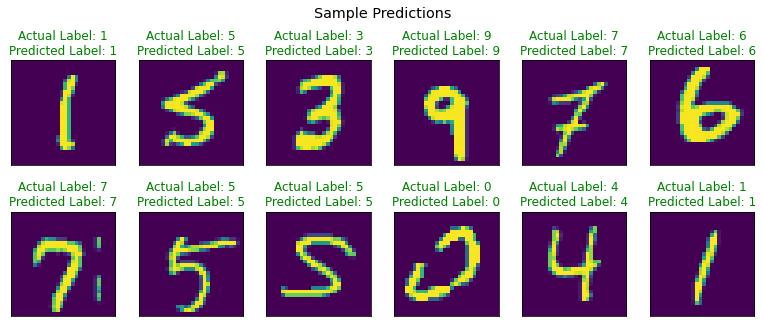

In [ ]:
y_pred = predict(model, X_test)
show_example(X_test, y_test, y_pred)

# Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB

## Without Dimention Reduction

In [ ]:
# Initialize Classifier
gnb_clf = GaussianNB()

# Train Classifier
gnb_clf.fit(X, y.ravel())

# Calculating training and test accuracy
gnb_train_acc = gnb_clf.score(X, y.ravel())
gnb_test_acc = gnb_clf.score(X_test, y_test.ravel())

print(f"Training Accuracy: {gnb_train_acc:.2%}")
print(f"Test Accuracy: {gnb_test_acc:.2%}")

Training Accuracy: 55.23%
Test Accuracy: 55.36%


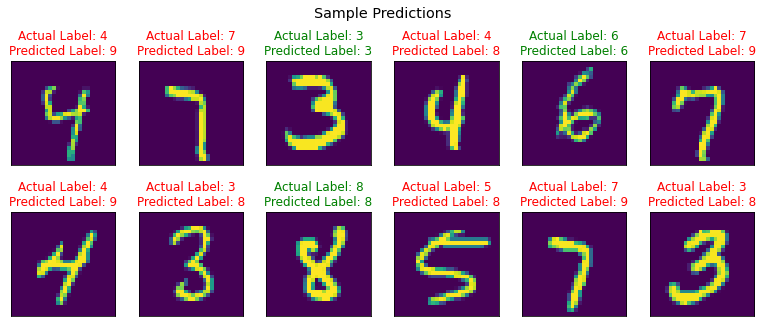

In [ ]:
y_pred = gnb_clf.predict(X_test)
show_example(X_test, y_test, y_pred)

## With Dimention Reduction

In [ ]:
pipe = Pipeline(steps=[
    ('pca', PCA()),
    ('gnb', GaussianNB())
])

param_grid = {
    'pca__n_components': np.linspace(0.8, 0.99, 20, endpoint=True)
}

gnb_clf = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1, cv=5, verbose=3)
gnb_clf.fit(X, y.ravel())

print(f"\nBest parameter (CV score={gnb_clf.best_score_:0.3f}):")
print(gnb_clf.best_params_)

gnb_train_acc = gnb_clf.score(X, y.ravel())
gnb_test_acc = gnb_clf.score(X_test, y_test.ravel())

print(f"\nTraining Accuracy: {gnb_train_acc:.2%}")
print(f"Test Accuracy: {gnb_test_acc:.2%}")


Best parameter (CV score=0.872):
{'pca__n_components': 0.88}

Training Accuracy: 87.28%
Test Accuracy: 88.09%


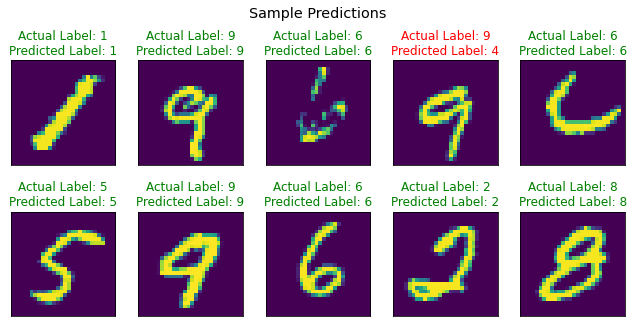

In [ ]:
y_pred = gnb_clf.predict(X_test)
show_example(X_test, y_test, y_pred)

# Support Vector Machine

In [ ]:
from sklearn.svm import SVC

## Without Dimension Reduction

In [ ]:
svm_clf = make_pipeline(
    StandardScaler(), 
    SVC()
)

svm_clf.fit(X, y.ravel())

svm_train_acc = svm_clf.score(X, y.ravel())
svm_test_acc = svm_clf.score(X_test, y_test.ravel())

print(f"Training Accuracy: {svm_train_acc:.2%}")
print(f"Test Accuracy: {svm_test_acc:.2%}")

Training Accuracy: 98.55%
Test Accuracy: 96.52%


In [ ]:
y_pred = svm_clf.predict(X_test)
print("Classification Report for SVC(C=1, gamma='scale'):")
print(f"{classification_report(y_test, y_pred)}")

Classification Report for SVC(C=1, gamma='scale'):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.97      0.96      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.96      0.97       982
           5       0.96      0.96      0.96       892
           6       0.98      0.97      0.97       958
           7       0.93      0.96      0.94      1028
           8       0.96      0.95      0.96       974
           9       0.97      0.93      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.96      0.96     10000
weighted avg       0.97      0.97      0.97     10000



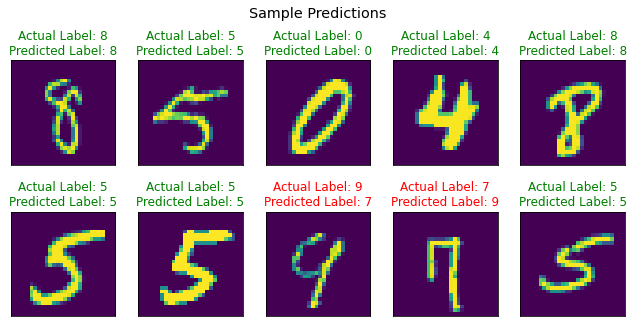

In [ ]:
y_pred = svm_clf.predict(X_test)
show_example(X_test, y_test, y_pred)

## With Dimension Reduction

In [ ]:
svm_clf = make_pipeline(
    PCA(n_components=0.90), 
    StandardScaler(), 
    SVC()
)

svm_clf.fit(X, y.ravel())

svm_train_acc = svm_clf.score(X, y.ravel())
svm_test_acc = svm_clf.score(X_test, y_test.ravel())

print(f"Training Accuracy: {svm_train_acc:.2%}")
print(f"Test Accuracy: {svm_test_acc:.2%}")

Training Accuracy: 99.52%
Test Accuracy: 98.10%


In [ ]:
y_pred = svm_clf.predict(X_test)
print("Classification Report for SVC(C=1, gamma='scale'):")
print(f"{classification_report(y_test, y_pred)}")

Classification Report for SVC(C=1, gamma='scale'):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.99      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.97      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



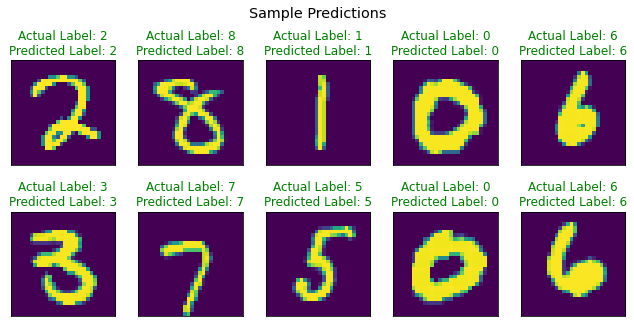

In [ ]:
show_example(X_test, y_test, y_pred)

# Decision Tree

In [ ]:
from sklearn import tree

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[('pca', PCA()), ('tree', tree.DecisionTreeClassifier())])

param_grid = {
    'pca__n_components': [0.9, 0.95, 0.99],
    'tree__max_depth': [10, 15, 20]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=4)
search.fit(X, y.ravel())

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 13.5min finished


Best parameter (CV score=0.827):
{'pca__n_components': 0.9, 'tree__max_depth': 15}


In [ ]:
tree_clf = make_pipeline(
    PCA(n_components=0.9),
    tree.DecisionTreeClassifier(max_depth=15)
)

tree_clf.fit(X, y.ravel())

tree_train_acc = tree_clf.score(X, y.ravel())
tree_test_acc = tree_clf.score(X_test, y_test.ravel())

print(f"Training Accuracy: {tree_train_acc:.2%}")
print(f"Test Accuracy: {tree_test_acc:.2%}")

Training Accuracy: 95.82%
Test Accuracy: 84.46%


In [ ]:
y_pred = tree_clf.predict(X_test)
print(f"Classification Report for {tree_clf}:")
print(f"{classification_report(y_test, y_pred)}")

Classification Report for Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=0.9,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=15,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False):
              precision    recal

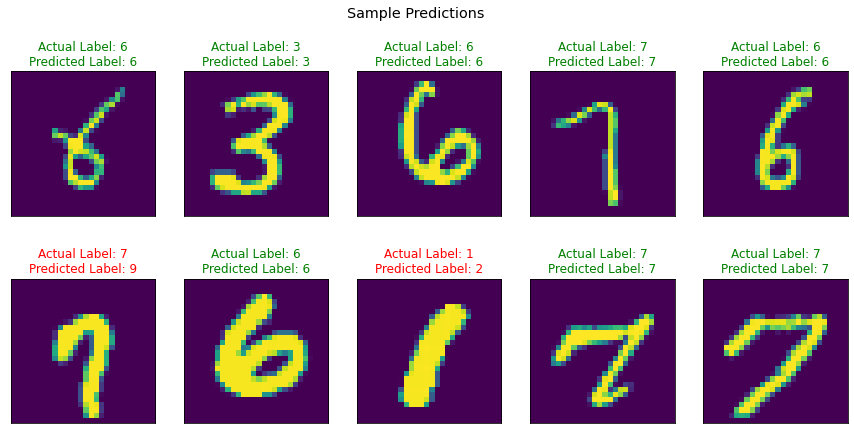

In [ ]:
sample_indices = np.random.choice(test_size, size=10, replace=False)

fig, axs = plt.subplots(2, 5)
fig.suptitle("Sample Predictions", fontsize='x-large')
fig.set_size_inches(15, 7)
axs = axs.ravel()
for ax_idx, im_idx in enumerate(sample_indices):
    image = X_test[im_idx].reshape(28, 28)
    axs[ax_idx].imshow(image)
    axs[ax_idx].get_xaxis().set_visible(False)
    axs[ax_idx].get_yaxis().set_visible(False)
    out_org, out_pred = y_test[im_idx, 0], y_pred[im_idx]
    axs[ax_idx].set_title(f"Actual Label: {y_test[im_idx, 0]}\n" \
                          f"Predicted Label: {y_pred[im_idx]}", 
                          color='green' if out_org == out_pred else 'red')
fig.show()